# XGBoost outcome model - learning curves

How much data do we need? Do we have enough?

One simple method is to examine how accuracy increases with training set size. Does accuracy plateau before we hit the limit to how much data we have? In that case, getting more data will not help the model significantly. Is accuracy still increasing as we reach the limit to our data size? If so we would likely benefit from more data, if we can get it.

But we will wrap the model in a loop to increase the training set data size (taking a different random training/test split each time, and keeping the test set the same size). We will have an inner loop to perform 10 replicates at each sample size (to reduce the variation in our results)


We will go through the following steps:

* Download and save pre-processed data
* Split data into features (X) and label (y)
* Split data into training and test sets (we will test on data that has not been used to fit the model)
* Standardise data
* Loop with increasing training set size:
    * Loop through 10 replicates
        * Fit a logistic regression model (from sklearn)
        * Predict survival of the test set
* Plot the relationship between training set size and accuracy

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.

In [66]:
# Import machine learning methods
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

from sklearn.metrics import confusion_matrix

import seaborn as sns

from sklearn.metrics import roc_auc_score

import time

Report the time duration to run notebook

In [ ]:
start_time = time.time()

## Set up paths and filenames

In [67]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = '../data/'
    data_read_filename: str = '02_reformatted_data_ml.csv'
    data_save_path: str = './'
    notebook: str = '04_'

paths = Paths()

## Load data

In [68]:
filename = os.path.join(paths.data_read_path, paths.data_read_filename)
data = pd.read_csv(filename)

In [69]:
features = list(data)
print(f"There are {len(features)} features")

There are 51 features


In [70]:
n_categories = data['discharge_disability'].nunique()
print(f'There are {n_categories} target categories')

There are 7 target categories


## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survive or not) `y`.

In [71]:
# Get X and y
X = data.drop('discharge_disability', axis=1)
y = data['discharge_disability']

## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [72]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [73]:
features_to_one_hot = ["stroke_team", "weekday"]#, "discharge_destination"]
list_prefix = ["team", "weekday"]#, "disch_dest"]

In [74]:

# One hot encode categorical features
for feature, prefix in zip(features_to_one_hot, list_prefix):
    X = convert_feature_to_one_hot(X, feature, prefix)

## Calculate the maximum training set size we can use 

In [75]:
test_fraction = 0.25 # Use 25% of data for testing
data_rows = X.shape[0]
max_training_size = int(data_rows * (1 - test_fraction))
print('Max training size: {}'.format(max_training_size))

Max training size: 57610


## Loop through increasing training set sizes 

In [76]:
# Set up list to collect results
results_training_size = []
results_roc_auc_ovr = []

for train_size in range(1000, max_training_size, 1000):
    replicate_roc_auc_ovr = []
    for replicate in range(10):
        y_train = np.array([])
        # Keep spliting until get one of each category in the training set
        while len(np.unique(y_train))!=n_categories:
            # Split data into training and test
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size = test_fraction)

            # Reduce training set size (use np random choice for random index values)
            selection_index = np.random.choice(
                max_training_size, train_size, replace=False)
            X_train = X_train.iloc[selection_index]
            y_train = y_train.iloc[selection_index]

        # Define model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_train, y_train)

        # Get target categories from model
        classes = model.classes_

        # Get predicted probabilities
        y_probs = model.predict_proba(X_test)

        # Calculate ROC AUC for multiclass models, using One vs Rest
        roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                    multi_class = 'ovr', average = 'macro')

        # Record results
        replicate_roc_auc_ovr.append(roc_auc_ovr)

    results_roc_auc_ovr.append(np.mean(replicate_roc_auc_ovr))
    results_training_size.append(train_size)

## Plot learning curve

We will plot the learning curve, including a moving average (the mean of 5 points). Moving averages can help show trends when data is noisy.

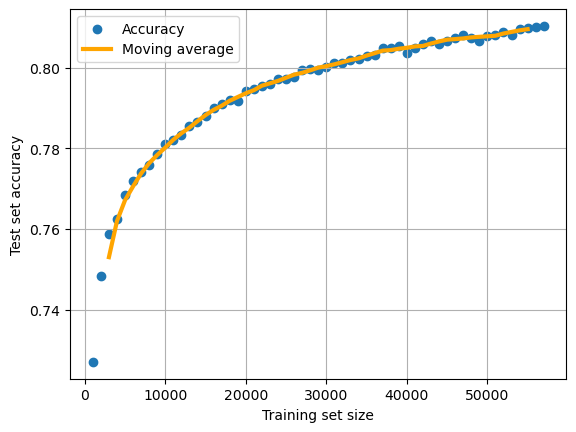

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate moving avergae (of last 5 points) with np.convolve
moving_average = np.convolve(results_roc_auc_ovr, np.ones((5,))/5, mode='valid')
x_moving_average = results_training_size[2:-2] # Include offset to centre mean

plt.scatter(results_training_size, results_roc_auc_ovr, 
         label='Accuracy')

plt.plot(x_moving_average, moving_average,
        label='Moving average',
        color='orange',
        linewidth=3)

plt.xlabel('Training set size')
plt.ylabel('Test set accuracy')
plt.legend()
plt.grid(True)
plt.show()

It appears that we need all, if not more, data to obtain the best accuracy.

In [ ]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')